In [1]:
import pandas as pd
diabetes = pd.read_csv('diabetes.csv')
diabetes

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [2]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

Najpierw pokażemy wyniki z modułu 14.4 (bez pipeline), dla najlepszego modelu z tamtego ćwiczenia.

In [6]:
from sklearn.linear_model import LogisticRegression

scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2000
           1       0.63      0.77      0.69      1000

    accuracy                           0.77      3000
   macro avg       0.75      0.77      0.76      3000
weighted avg       0.79      0.77      0.78      3000



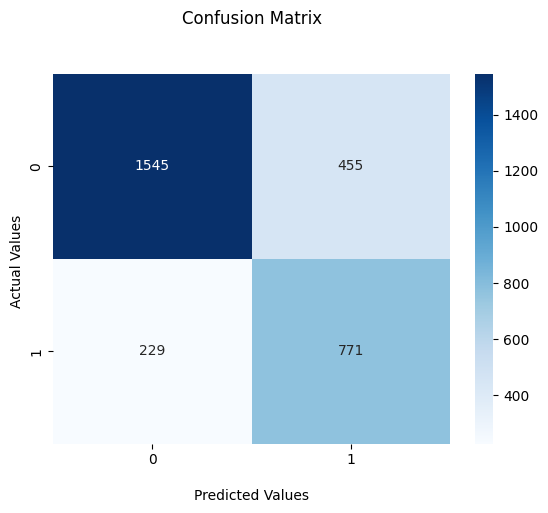

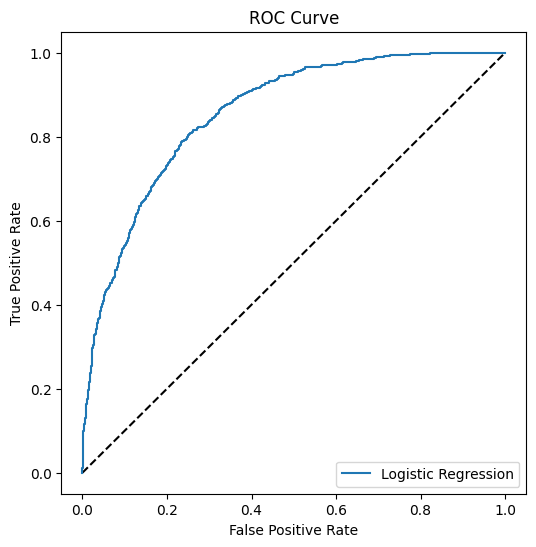

C:\Users\user\AppData\Local\Temp\ipykernel_15536\2045065270.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.692722,0.856337


In [7]:
model = LogisticRegression(C=0.01, penalty='l1', class_weight='balanced', solver='liblinear', max_iter=1000)
model.fit(X_train_standardized, y_train)
calculate_metrics(model, 'Logistic Regression', X_test_standardized, y_test)

In [8]:
from sklearn.svm import SVC

In [9]:
# W tym wypadku wszystkie zmienne niezależne są numeryczne.
num_features = features

# przygotowanie wartosci numerycznych
num_preparation = Pipeline(steps=[('fill_missings', SimpleImputer(strategy='mean')),
                                  ('polynomial_features', PolynomialFeatures(degree=3)),
                                  ('scaler_1', StandardScaler()),
                                  ('pca', PCA(n_components=0.95)),
                                  ('scaler_2', StandardScaler())])

# transformer = wartosci numeryczne
data_preparation = ColumnTransformer(transformers=[('numeric_preprocessing', num_preparation, num_features)])

15.5

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2000
           1       0.83      0.75      0.79      1000

    accuracy                           0.87      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.86      0.87      0.86      3000



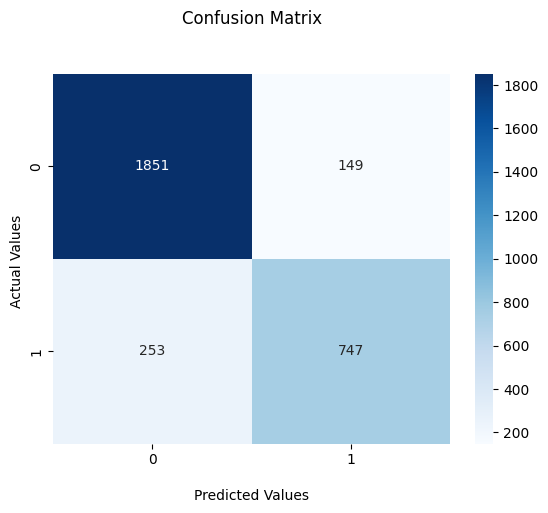

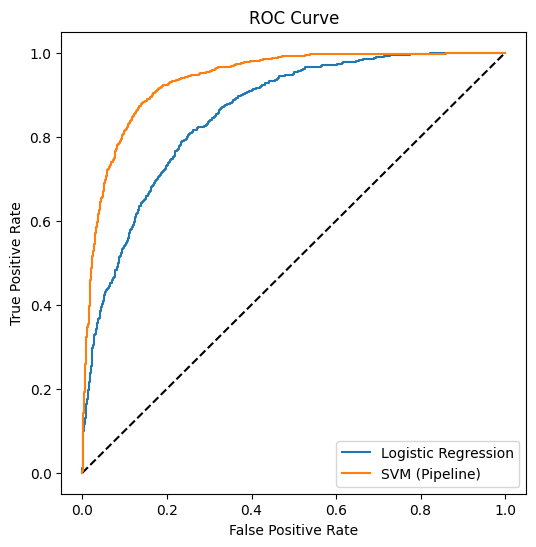

,Model,F1_score,AUC
0,Logistic Regression,0.692722,0.856337
1,SVM (Pipeline),0.787975,0.937542


In [10]:
model_pipeline_svm = Pipeline(steps=[('preprocessor', data_preparation), ('model', SVC(probability=True))])
model_pipeline_svm.fit(X_train, y_train)
calculate_metrics(model_pipeline_svm, 'SVM (Pipeline)', X_test, y_test)

Wyraźnie widzimy, że nasze wyniki znacznie poprawiły się wraz z użyciem pipeline!

BELOW: 15.6

In [11]:
model_pipeline = Pipeline(steps=[('preprocessor', data_preparation), ('model', SVC(probability=True))])
list(model_pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__force_int_remainder_cols',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pre

In [12]:
params = {'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
          'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
          'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99],
          'model__kernel': ['linear', 'poly', 'rbf']}

grid_search = GridSearchCV(model_pipeline, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')

grid_search.fit(X_train, y_train)

print('Wybrane hiperparametry: ', grid_search.best_params_)
model_svm = grid_search.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Wybrane hiperparametry:  {'model__kernel': 'rbf', 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.9, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 1}


              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2000
           1       0.86      0.80      0.83      1000

    accuracy                           0.89      3000
   macro avg       0.88      0.86      0.87      3000
weighted avg       0.89      0.89      0.89      3000



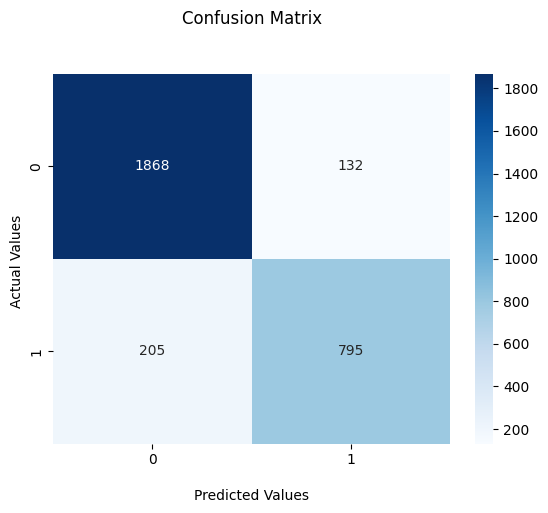

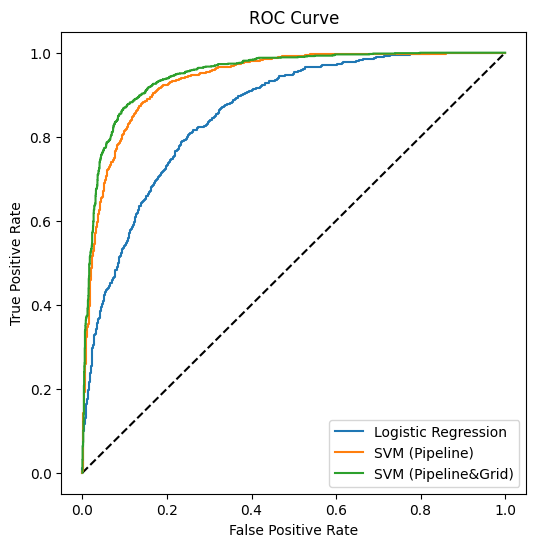

,Model,F1_score,AUC
0,Logistic Regression,0.692722,0.856337
1,SVM (Pipeline),0.787975,0.937542
2,SVM (Pipeline&Grid),0.825117,0.949481


In [13]:
calculate_metrics(model_svm, 'SVM (Pipeline&Grid)', X_test, y_test)

Grid search dodatkowo ulepszył nasze wyniki.